# TFG Migración y turismo inteligente.

Modelos de IA para análisis y visualización. 

# EDA forecasting

Empiezo a realizar un análisis exploratorio del dataset filtrado con el objetivo de realizar modelos de predicción (forecasting).

Para ello, 

1. Se debe cambiar el formato de tiempo a datetime.
2. Se deben agregar los totales por pares de rutas (comunidad-país de origen)
3. Determinar periodos faltantes para saber que cobertura tenemos y que rutas se pueden usar para forecasting robusto.

* Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, third edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. Accessed on <18/04/2025>.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
csv = '13884_filtrado.csv'
df = pd.read_csv(csv, encoding='utf-8-sig')

# Creación de datetime
df['Periodo'] = df['Periodo'].astype(str)
df['year'] = df['Periodo'].str.extract(r'(\d{4})').astype(int)
df['month'] = df['Periodo'].str.extract(r'M(\d{2})').astype(int)
df['Periodo_dt'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

# Agregación por comunidad, país y mes
df_agg = (
    df.groupby(['Comunidad autónoma de destino', 'País de residencia', 'Periodo_dt'], as_index=False)
      .agg({'Total': 'sum'}))

print(f"Filas originales: {len(df):,}. Filas agregadas: {len(df_agg):,}.")

# Conocer el rango de meses de que disponemos
min_date, max_date = df_agg['Periodo_dt'].min(), df_agg['Periodo_dt'].max()
rango_completo = pd.date_range(start=min_date, end=max_date, freq='MS')
total_periodos = len(rango_completo)

print(f"Periodo temporal: {min_date.strftime('%B %Y')} a {max_date.strftime('%B %Y')} ({total_periodos} meses)")

# Conocer la cobertura para ir desestimando pares de rutas
cobertura = (
    df_agg.groupby(['Comunidad autónoma de destino', 'País de residencia'])['Periodo_dt']
    .agg(n_periodos_distintos='nunique',
         primer_periodo='min',
         ultimo_periodo='max')
    .reset_index())

cobertura['n_faltantes'] = total_periodos - cobertura['n_periodos_distintos']
cobertura['porcentaje_cobertura'] = (cobertura['n_periodos_distintos'] / total_periodos * 100).round(1)

# Estadísticas
cobertura = cobertura.sort_values('porcentaje_cobertura', ascending=False)

print(f"Promedio de periodos distintos: {cobertura['n_periodos_distintos'].mean():.1f} / {total_periodos}")
print(f"Cobertura media: {cobertura['porcentaje_cobertura'].mean():.1f}%")
print(f"Combinaciones totales: {len(cobertura)}")
validas = cobertura[cobertura['porcentaje_cobertura'] >= 50]
print(f"Combinaciones válidas (>=50% cobertura): {len(validas)}")

Filas originales: 15,013. Filas agregadas: 4,130.
Periodo temporal: October 2015 a December 2024 (111 meses)
Promedio de periodos distintos: 34.4 / 111
Cobertura media: 31.0%
Combinaciones totales: 120
Combinaciones válidas (>=50% cobertura): 32


* El dataset se ha reducido notablemente con la agregación.
* Se ha detectado que no todas las combinaciones posibles disponen de todos los datos. Esto afectará a las rutas disponibles para hacer forecasting. 

Se procede a analizar con mas detalle las combinaciones para quedarnos con aquellas que tengan mayor cobertura y generar modelos robustos (considero aquellos que tienen un porcentaje de cobertura del 50% o más, o al menos 24 meses).

,nivel,n_combinaciones
0,Baja,88
1,Alta,16
2,Media,16


Combinaciones válidas para forecasting: 60 (50.0%)


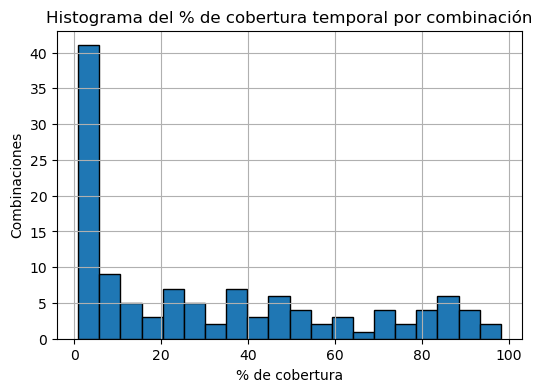

In [7]:
# Clasificación de cobertura
def clasificar_cobertura(pct):
    if pct >= 80:
        return 'Alta'
    elif pct >= 50:
        return 'Media'
    else:
        return 'Baja'

cobertura['nivel_cobertura'] = cobertura['porcentaje_cobertura'].apply(clasificar_cobertura)

resumen = cobertura['nivel_cobertura'].value_counts().rename_axis('nivel').reset_index(name='n_combinaciones')
display(resumen)

# Ejemplos validos para el forecasting. 24 meses o 50% cobertura
validas = cobertura[
    (cobertura['n_periodos_distintos'] >= 24) |
    (cobertura['porcentaje_cobertura'] >= 50)
]

print(f"Combinaciones válidas para forecasting: {len(validas)} ({len(validas)/len(cobertura)*100:.1f}%)")

plt.figure(figsize=(6,4))
cobertura['porcentaje_cobertura'].hist(bins=20, edgecolor='black')
plt.title('Histograma del % de cobertura temporal por combinación')
plt.xlabel('% de cobertura')
plt.ylabel('Combinaciones')
plt.show()

Se observa que podemos tener unas 60 combinaciones validas por % de cobertura. 

Existe un % elevado de combinaciones con casi nula cobertura, lo que refuerza la imagen del mapa de calor del anterior notebook (EDA) y se determina 

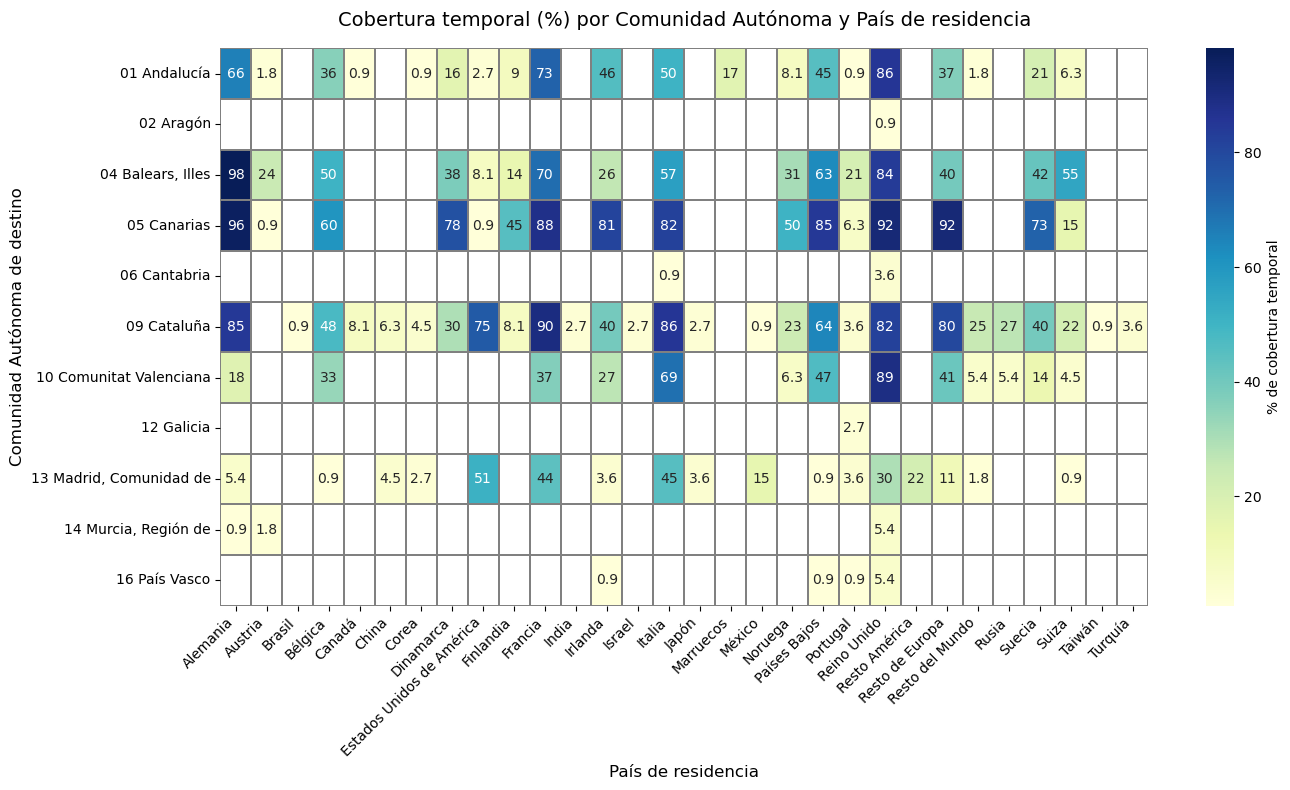

In [9]:
heatmap_data = cobertura.pivot_table(
    index='Comunidad autónoma de destino',
    columns='País de residencia',
    values='porcentaje_cobertura'
)

plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    cmap='YlGnBu',          
    annot=True,            
    cbar_kws={'label': '% de cobertura temporal'},
    linewidths=0.3,
    linecolor='gray'
)

plt.title('Cobertura temporal (%) por Comunidad Autónoma y País de residencia', fontsize=14, pad=16)
plt.xlabel('País de residencia', fontsize=12)
plt.ylabel('Comunidad Autónoma de destino', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

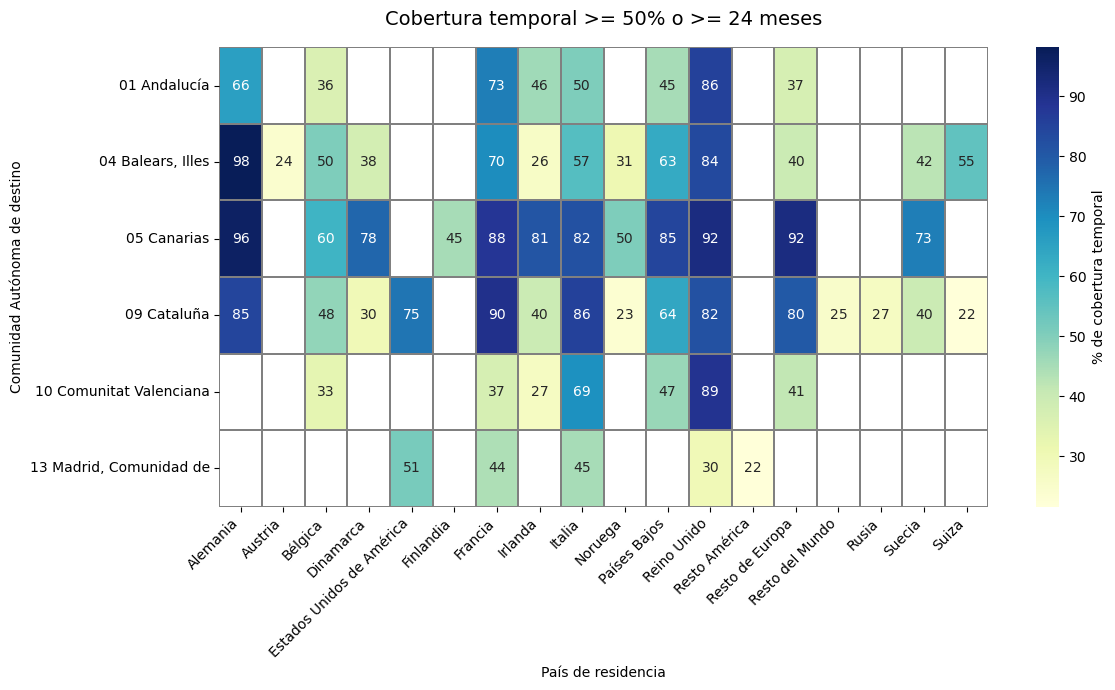

In [10]:
# Crear la matriz para el heatmap filtrado
heatmap_validas = validas.pivot_table(
    index='Comunidad autónoma de destino',
    columns='País de residencia',
    values='porcentaje_cobertura'
)

plt.figure(figsize=(12, 7))
sns.heatmap(
    heatmap_validas,
    cmap='YlGnBu',
    annot=True, fmt=".0f", 
    cbar_kws={'label': '% de cobertura temporal'},
    linewidths=0.3,
    linecolor='gray'
)

plt.title('Cobertura temporal >= 50% o >= 24 meses', fontsize=14, pad=16)
plt.xlabel('País de residencia')
plt.ylabel('Comunidad Autónoma de destino')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [11]:
# Se filtran los datos con las combinaciones válidas y se genera un csv
df_forecasting = df_agg.merge(
    validas[['Comunidad autónoma de destino', 'País de residencia']],
    on=['Comunidad autónoma de destino', 'País de residencia'],
    how='inner'
).sort_values(['Comunidad autónoma de destino', 'País de residencia', 'Periodo_dt'])

df_forecasting.to_csv('df_forecasting.csv', index=False, encoding='utf-8-sig')

print(f"Dataset final para forecasting guardado ({len(df_forecasting):,} filas)")
display(df_forecasting.head(10))

Dataset final para forecasting guardado (3,764 filas)


,Comunidad autónoma de destino,País de residencia,Periodo_dt,Total
0,01 Andalucía,Alemania,2015-10-01,42178
1,01 Andalucía,Alemania,2015-11-01,30450
2,01 Andalucía,Alemania,2015-12-01,10989
3,01 Andalucía,Alemania,2016-03-01,19441
4,01 Andalucía,Alemania,2016-04-01,59618
5,01 Andalucía,Alemania,2016-05-01,45208
6,01 Andalucía,Alemania,2016-08-01,63534
7,01 Andalucía,Alemania,2016-09-01,75817
8,01 Andalucía,Alemania,2017-03-01,42100
9,01 Andalucía,Alemania,2017-04-01,105758


Una vez generado el nuevo dataset y csv sobre el que se va a trabajar el forecasting, se visualizan algunas rutas.

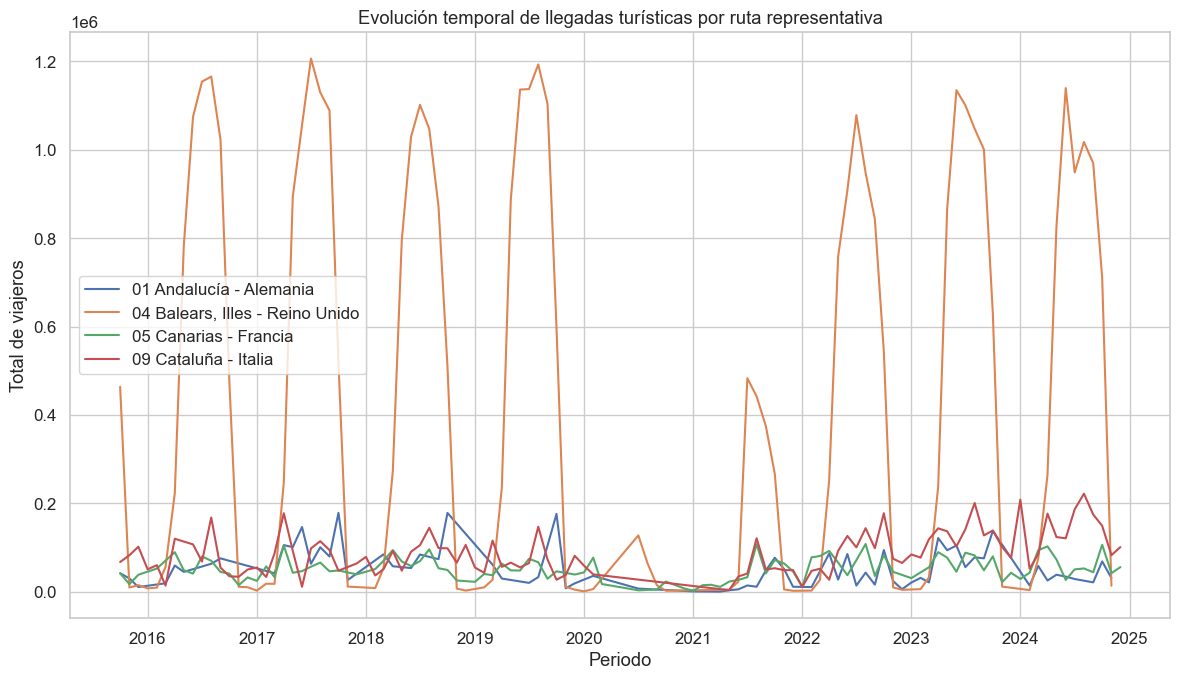

In [13]:
df = pd.read_csv("df_forecasting.csv", encoding="utf-8-sig")

df["Periodo_dt"] = pd.to_datetime(df["Periodo_dt"], errors="coerce")
df["Total"] = pd.to_numeric(df["Total"], errors="coerce")

# Se determinan algunas rutas
rutas = [
    ("01 Andalucía", "Alemania"),
    ("04 Balears, Illes", "Reino Unido"),
    ("05 Canarias", "Francia"),
    ("09 Cataluña", "Italia")
]

df_filtrado = df[df[["Comunidad autónoma de destino", "País de residencia"]]
                 .apply(tuple, axis=1).isin(rutas)]


sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(12, 7))

for comunidad, pais in rutas:
    subset = df_filtrado[(df_filtrado["Comunidad autónoma de destino"] == comunidad) &
                         (df_filtrado["País de residencia"] == pais)]
    plt.plot(subset["Periodo_dt"], subset["Total"], label=f"{comunidad} - {pais}")

plt.title("Evolución temporal de llegadas turísticas por ruta representativa")
plt.xlabel("Periodo")
plt.ylabel("Total de viajeros")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Tras la agregacion por comunidad, pais de origen y periodo el dataset decreció drasticamente. 
Además, no todas las combinaciones de comunidad y pais tienen suficientes datos para hacer un forecasting robusto. Se considera que al menos deben tener una cobertura de 24 meses para que los resultados del modelo sean validos.
Además, se puede observar que los años 2020 y 2021 introducen un cambio importante debido a la pandemia COVID-19 y la paralización de los viajes. 
Para el forecasting se considerará usar solo los años 2022, 2023 y 2024 para el análisis.